<a href="https://colab.research.google.com/github/Eoli-an/Exam-topic-prediction/blob/main/Copy_of_Slides_vs_Transcribes_Frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot for Dense Ranks of Word Usage in Slides and Transcribes of Relevant Words

For this plot we analyse the relationship between the word frequency of the slides versus the word frequency of the transcribes of the lecture. We only analyse hand picked words that are relevant for predicting exam topics or their difficulties.

In [ ]:
!pip install scattertext
!pip install tika
!pip install textblob

     |████████████████████████████████| 7.3 MB 3.7 MB/s 
     |████████████████████████████████| 24.1 MB 6.0 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=d7ddfda4838a50a0e01255e7eb289e13c2e5ff760f9b942a589faf9bd070e251
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32893 sha256=510c46fdd39035d4d9a50aedbd8895289a6de5921988025067f7ca544e9c18a5
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika


In [ ]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scattertext as st
from tika import parser
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

The Slides are expected to be in a folder called Slides. The Transcibes are expected to be in a folder called Transcribes

In [ ]:
lectures_spoken = []
path = 'Transcribes/*.txt'
files=glob.glob(path)
for file in sorted(files):
    with open(file, 'r') as f:
        lectures_spoken.append(f.read())
lectures_spoken = " ".join(lectures_spoken)

In [ ]:
lectures_pdf = []
path = 'Slides/*.pdf'
files=glob.glob(path)
for file in sorted(files):
      lectures_pdf.append(parser.from_file(file)["content"])
lectures_pdf = " ".join(lectures_pdf)

Create a texblob of the text. This is used to extract the noun phrases.

In [ ]:
blob_spoken = TextBlob(lectures_spoken)
freq_spoken = nltk.FreqDist(blob_spoken.noun_phrases)

In [ ]:
blob_pdf = TextBlob(lectures_pdf)
freq_pdf = nltk.FreqDist(blob_pdf.noun_phrases)

This function checks if a noun phrase is sufficiently similar to a relevant word(templates). Sufficiently similar is defined as that the template is a substring of the noun phrase.

In [ ]:
def convert_to_template(df_element, template):
  for template_element in template:
    if template_element in df_element:
      return template_element
  return "None"


We first create a pandas dataframe of all the noun phrases and their frequencies in bot slides and transcribes. After that, we extract all words that are similar to a relevant word (as of the convert_to_template function). Then we group by the relevant words

In [ ]:
relevant_words = ['bayes', 'frequentist', 'fairness', 'divergence', 'reproduc', 'regulariz', 'pca', 'principal c' 'bootstrap', 'nonlinear function', 'linear function', 'entropy', 'maximum likelihood estimat', 'significa', 'iid', 'bayes theorem', 'visualization', 'score function', 'dimensionality reduction', 'estimat', 'bayes', 'consumption', 'fisher', 'independence', 'logistic regression', 'bias', 'standard deviation', 'linear discriminant analysis', 'information matrix', 'null hypothesis', 'log likelihood', 'linear regression', 'hypothesis test', 'confidence', 'variance', 'sustainability', 'gaussian', 'linear model', 'climate', 'laplace', ]

In [ ]:
df_spoken = pd.DataFrame.from_dict({"word": list(freq_spoken.keys()), "freq_spoken" : list(freq_spoken.values())})
df_pdf = pd.DataFrame.from_dict({"word": list(freq_pdf.keys()), "freq_pdf" : list(freq_pdf.values())})
df = df_spoken.merge(df_pdf,how="outer",on="word")
df["word"] = df["word"].apply(lambda x: convert_to_template(x,relevant_words))
df = df.groupby(["word"]).sum().reset_index()
df = df[df["word"] != "None"].reset_index()

We use the dense_rank functionality of the scattertext library to convert the absolute number of occurances of a word to a dense rank. This means that we only consider the relative order of the frequencies of the word and discard all information that tells us how far apart two word frequencies are. 

In [ ]:
df["freq_spoken"] = st.Scalers.dense_rank(df["freq_spoken"])
df["freq_pdf"] = st.Scalers.dense_rank(df["freq_pdf"])

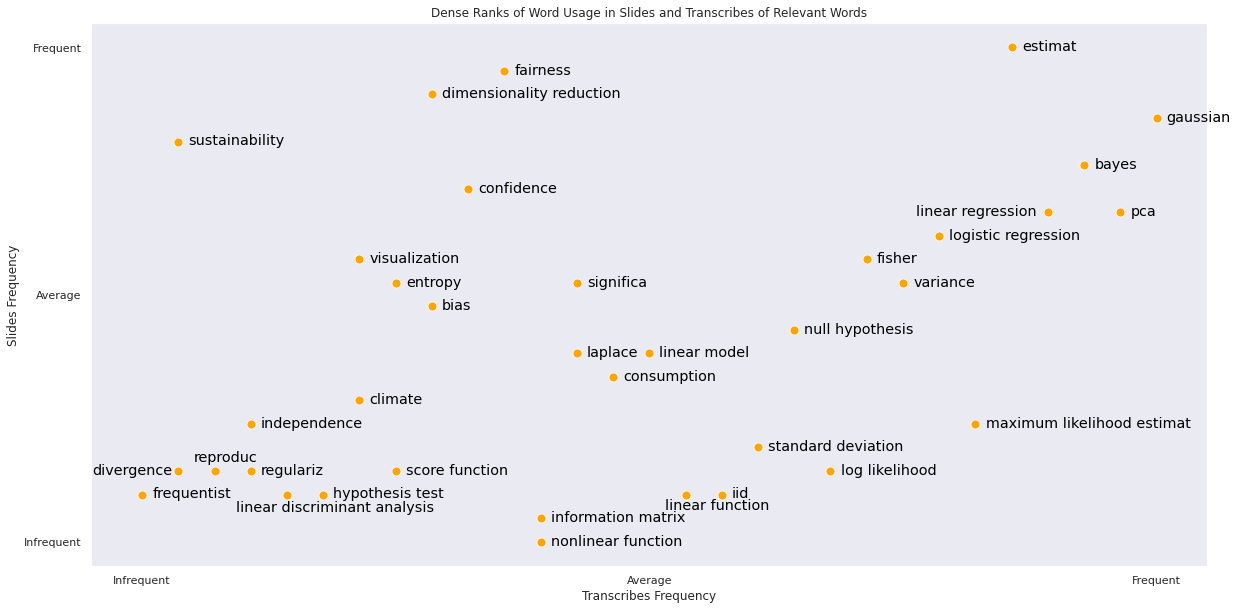

In [ ]:


plt.figure(figsize=(20,10))
sns.set_theme(style="dark")
p1 = sns.scatterplot(x='freq_spoken', # Horizontal axis
       y='freq_pdf', # Vertical axis
       data=df, # Data source
       s = 80,
       legend=False,
       color="orange",
       #marker = "s"
       )  

for line in range(0,df.shape[0]):
    if line == 6:#divergence
      p1.text(df.freq_spoken[line]-0.085, df.freq_pdf[line]-0.007, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')
    elif line == 21:#linear regression
      p1.text(df.freq_spoken[line]-0.13, df.freq_pdf[line]-0.007, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')
    elif line == 18:#linear discriminant analysis
      p1.text(df.freq_spoken[line]-0.05, df.freq_pdf[line]-0.035, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')
    elif line == 19:#linear function
      p1.text(df.freq_spoken[line]-0.02, df.freq_pdf[line]-0.03, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')
    elif line == 29:#reproduce
      p1.text(df.freq_spoken[line]-0.02, df.freq_pdf[line]+0.02, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')
    else:
      p1.text(df.freq_spoken[line]+0.01, df.freq_pdf[line]-0.007, 
        df.word[line], horizontalalignment='left', 
        size='large', color='black', weight='normal')


plt.title('Dense Ranks of Word Usage in Slides and Transcribes of Relevant Words')
# Set x-axis label
plt.xlabel('Transcribes Frequency')
# Set y-axis label
plt.ylabel('Slides Frequency')

p1.set_xticks([0,0.5,1]) # <--- set the ticks first
p1.set_xticklabels(["Infrequent", "Average", "Frequent"])

p1.set_yticks([0,0.5,1]) # <--- set the ticks first
p1.set_yticklabels(["Infrequent", "Average", "Frequent"])
plt.show()